# 랭킹 올리기! 
## 최적의 모델을 위한 데이터 준비하기 

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt   #  matplotlib 시각화
import seaborn as sns

### 데이터 전처리

In [7]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('완료 !')

완료 !


In [8]:
# 데이터 살펴보기
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
# date int형으로 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
# price 컬럼 전처리 - train에서 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# id 컬럼까지 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [12]:
# test 데이터에도 똑같이~ (date, id)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [13]:
# 타겟 데이터 y 
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

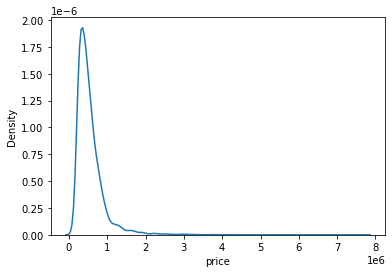

In [14]:
# seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인 - 가격 데이터 분포
sns.kdeplot(y)
plt.show()

In [15]:
# y 로그 변환 -> 정규화 그래프
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

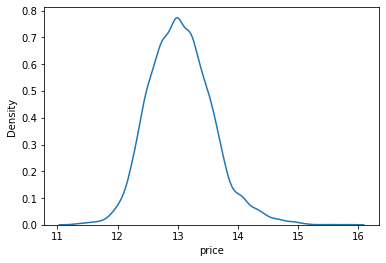

In [16]:
sns.kdeplot(y)
plt.show()

In [17]:
# info() 함수로 전체 데이터 자료형 확인 - 실수/정수이다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 모델 튜닝
- XGBoosting
- LightGBM
- Gradient Boosting
- Random Forest  

### RMSE 계산 - 평균 제곱근 오차

In [18]:
from sklearn.model_selection import train_test_split  # 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위해
from sklearn.metrics import mean_squared_error # RMSE 점수를 계산하기 위해

print('라이브러리 불러오기!')

라이브러리 불러오기!


In [19]:
# y_test, y_pred는 위에서 np.log1p()로 변환 된 값 
# 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1() 추가
# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하기 (RMSE 값)

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('RMSE 값 준비 완료!')

RMSE 값 준비 완료!


In [20]:
# 모델 불러오기 (XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('모델 불러오기 완료')

모델 불러오기 완료


**random_state**  
- 1) **특정 값 고정** : 모델과 데이터셋이 동일한 경우, 머신러닝 학습결과도 항상 동일
- 2) **None** : 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라고 머신러닝 학습결과는 학습할 때마다 달라진다.  
  
모델을 돌릴 때마다 랜덤적 요소의 변화로 생기는 불확실성 제거 -> 특정 값 고정  

In [21]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest] # 모델 인스턴스 생성 후 models 리스트에 넣어줌

print('모델 인스턴스 생성 완료!')

모델 인스턴스 생성 완료!


In [22]:
# 각 모델의 이름은 클래스의 '__name__' 속성으로 얻을 수 있음
gboost.__class__.__name__

'GradientBoostingRegressor'

In [24]:
# 위를 이용하여 for문 안에서 각 모델 별로 학습 및 예측 가능
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
print("4가지 모델에 대한 RMSE 값 빠르게 얻을 수 있다.")
df

4가지 모델에 대한 RMSE 값 빠르게 얻을 수 있다.


{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [26]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__  # 모델 이름 받아오기
        
        X_train, X_test, y_train, y_test = train_test_split(train,y, random_state = 2020, test_size = 0.2)
        model.fit(X_train,y_train) # 모델 학습
        y_pred = model.predict(X_test) # 모델 예측
        
        df[model_name] = rmse(y_test,y_pred)  # 예측값을 rmse로 딕셔너리 저장
        score_df = pd.DataFrame(df,index = ['RMSE']).T.sort_values('RMSE', ascending=False)
        # data frame으로 저장
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


### 하이퍼파라미터 - 그리드 탐색 
- **Grid Search** : 격자를 정해놓고 탐색하는 방법 / 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두면, 그 값들로 만들어질 수 있는 모든 조합을 탐색  

      
    - param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    - scoring : 모델의 성능을 평가할 지표
    - cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    - verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    - n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

- **Random Search** : 사람이 하이퍼 파라미터 공간만 정해두면, 그 안에서 랜덤으로 조합을 탐색함 

In [31]:
# sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용
from sklearn.model_selection import GridSearchCV

In [65]:
# param_grid에 탐색할 xgboost관련 하이퍼 파라미터 넣어서 준비
param_grid = {
    'num_leaves' : [31],
    'n_estimators': [50, 100,150,200],
    'max_depth': [10,20,30,40],
    'learning_rate' : [0.005],
    'feature_fraction' : [0.5]
}

In [66]:
# 모델 준비 : LightGBM(lgbm) 사용
model = LGBMRegressor(random_state=random_state)

print('모델 준비 완료')

모델 준비 완료


In [67]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:    4.1s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'feature_fraction': [0.5], 'learning_rate': [0.005],
                         'max_depth': [10, 20, 30, 40],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [31]},
             scoring='neg_mean_squared_error', verbose=1)


위에서 우리가 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지입니다.     

또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행하게 됩니다.

여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

In [68]:
# grid_model.fit함수를 통해 4가지 조합에 대한 실험 완료 

grid_model.cv_results_    # 이 안에 모두 저장 되어있음

{'mean_fit_time': array([0.11564236, 0.1891746 , 0.25791264, 0.33278604, 0.10549407,
        0.18600125, 0.2637629 , 0.33768706, 0.10804415, 0.19470448,
        0.26375847, 0.33904004, 0.10899982, 0.18990889, 0.25414462,
        0.29249282]),
 'std_fit_time': array([0.00531565, 0.00772651, 0.00753965, 0.00660043, 0.00329538,
        0.00132769, 0.00929734, 0.01271431, 0.00604125, 0.01090066,
        0.00682137, 0.00607263, 0.01044474, 0.00475019, 0.01328401,
        0.03800999]),
 'mean_score_time': array([0.00839987, 0.01365938, 0.01923933, 0.02648005, 0.00779257,
        0.01320109, 0.0202745 , 0.02647638, 0.00799365, 0.01438127,
        0.02057047, 0.02651038, 0.00799265, 0.01353335, 0.01980891,
        0.02333436]),
 'std_score_time': array([0.00076316, 0.00074791, 0.00112904, 0.0005671 , 0.00061345,
        0.00096837, 0.00113494, 0.00049005, 0.00027028, 0.00119503,
        0.00101029, 0.00095998, 0.00037378, 0.00071497, 0.00050419,
        0.00201168]),
 'param_feature_fraction':

In [69]:
# 무슨말이야? 원하는 값만 정제해서 보자 - 어떤 파라미터 조합일 때 점수가 어떻게 나오는가
params = grid_model.cv_results_['params']   # 파라미터 조합 params에 저장되어있음
params

[{'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 50,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 100,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 150,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 200,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 20,
  'n_estimators': 50,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 20,
  'n_estimators': 100,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 20,
  'n_estimators': 150,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 20,
  'n_estimators': 200,
  'num_leaves': 31},
 {'feature_fraction': 0.5,
  'learning_rate': 0.005,
  'max_depth': 30,
  

In [70]:
score = grid_model.cv_results_['mean_test_score']  # 각각에 대한 테스트 점수는 mean_test_score에 저장되어있음
score

array([-0.20003612, -0.14774305, -0.11396442, -0.09040023, -0.20003629,
       -0.14774865, -0.11395099, -0.09041306, -0.20003629, -0.14774865,
       -0.11395099, -0.09041306, -0.20003629, -0.14774865, -0.11395099,
       -0.09041306])

### 최적의 성능을 내는 하이퍼 파라미터 조합 찾기
- params : 각 파라미터 조합
- score : 각 조합에 대한 점수
    - 왜 음수일까? :MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했다.

In [71]:
results = pd.DataFrame(params)
results['score'] = score

results

,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score
0,0.5,0.005,10,50,31,-0.200036
1,0.5,0.005,10,100,31,-0.147743
2,0.5,0.005,10,150,31,-0.113964
3,0.5,0.005,10,200,31,-0.090400
4,0.5,0.005,20,50,31,-0.200036
5,0.5,0.005,20,100,31,-0.147749
6,0.5,0.005,20,150,31,-0.113951
7,0.5,0.005,20,200,31,-0.090413
8,0.5,0.005,30,50,31,-0.200036
9,0.5,0.005,30,100,31,-0.147749


In [72]:
# 음수 MSE * -1 해주고 np.sqrt로 루트연산 
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSE
0,0.5,0.005,10,50,31,-0.200036,0.447254
1,0.5,0.005,10,100,31,-0.147743,0.384374
2,0.5,0.005,10,150,31,-0.113964,0.337586
3,0.5,0.005,10,200,31,-0.090400,0.300666
4,0.5,0.005,20,50,31,-0.200036,0.447254
5,0.5,0.005,20,100,31,-0.147749,0.384381
6,0.5,0.005,20,150,31,-0.113951,0.337566
7,0.5,0.005,20,200,31,-0.090413,0.300688
8,0.5,0.005,30,50,31,-0.200036,0.447254
9,0.5,0.005,30,100,31,-0.147749,0.384381


위에서 본 RMSE 값과 크기가 아주 다르다.  
- 원래 price 분포는 한쪽으로 치우쳐져 있음 -> log변환 해주고 -> rmse 값 계산을 위해 np.expm1 함수 활용해 원래대로 복원 -> RMSE 값 계산  
  
- 그리드 탐색 (np.expm 변환 과정이 없었음) : log변환 되어있는 price 데이터에서 손실함수값 계산함
    - RMSLE (Root Mean Squared Log Error) : log를 취한 값에서 RMSE 구함 

In [73]:
# 컬럼이름 변경 (RMSLE) 
results = results.rename(columns={'RMSE': 'RMSLE'}) # 컬럼의 이름 변환 - rename
results

,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,0.5,0.005,10,50,31,-0.200036,0.447254
1,0.5,0.005,10,100,31,-0.147743,0.384374
2,0.5,0.005,10,150,31,-0.113964,0.337586
3,0.5,0.005,10,200,31,-0.090400,0.300666
4,0.5,0.005,20,50,31,-0.200036,0.447254
5,0.5,0.005,20,100,31,-0.147749,0.384381
6,0.5,0.005,20,150,31,-0.113951,0.337566
7,0.5,0.005,20,200,31,-0.090413,0.300688
8,0.5,0.005,30,50,31,-0.200036,0.447254
9,0.5,0.005,30,100,31,-0.147749,0.384381


In [74]:
# RMSLE 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
3,0.5,0.005,10,200,31,-0.090400,0.300666
7,0.5,0.005,20,200,31,-0.090413,0.300688
11,0.5,0.005,30,200,31,-0.090413,0.300688
15,0.5,0.005,40,200,31,-0.090413,0.300688
6,0.5,0.005,20,150,31,-0.113951,0.337566
10,0.5,0.005,30,150,31,-0.113951,0.337566
14,0.5,0.005,40,150,31,-0.113951,0.337566
2,0.5,0.005,10,150,31,-0.113964,0.337586
1,0.5,0.005,10,100,31,-0.147743,0.384374
5,0.5,0.005,20,100,31,-0.147749,0.384381


In [75]:
# 함수로 조합해서 만들어보기!
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):     #(1)
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

    grid_model.fit(train, y)     # (2)
    
    # 어떤 파라미터 조합일 때 점수가 어떻게 나오는가 (3)
    params = grid_model.cv_results_['params']   # 파라미터 조합 params에 저장되어있음

    score = grid_model.cv_results_['mean_test_score']  # 각각에 대한 테스트 점수는 mean_test_score에 저장되어있음

    # (4)
    results = pd.DataFrame(params)
    results['score'] = score

    # 음수 MSE * -1 해주고 np.sqrt로 루트연산 
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    # RMSLE 낮은 순서대로 정렬
    results = results.sort_values('RMSLE')

    return results

In [131]:
# my_GridSearch() 함수를 통해 간단한 그리드 탐색 


                
param_grid = {
    'num_leaves' : [31],
    'n_estimators': [600,800,1000],
    'max_depth': [10,20,30,40],
    'learning_rate' : [0.05],
    'feature_fraction' : [0.5]

}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   15.3s finished


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
4,0.5,0.05,20,800,31,-0.025486,0.159642
7,0.5,0.05,30,800,31,-0.025494,0.159667
10,0.5,0.05,40,800,31,-0.025494,0.159667
5,0.5,0.05,20,1000,31,-0.025508,0.159713
1,0.5,0.05,10,800,31,-0.025512,0.159725
3,0.5,0.05,20,600,31,-0.025518,0.159745
6,0.5,0.05,30,600,31,-0.025518,0.159745
9,0.5,0.05,40,600,31,-0.025518,0.159745
2,0.5,0.05,10,1000,31,-0.025528,0.159776
0,0.5,0.05,10,600,31,-0.025531,0.159785


### 가장 좋은 조합으로 모델 학습 -> 예측값 submission.csv 파일로 만들어 제출
-  max_depth=10, n_estimators=100

In [132]:
# 파라미터로 구성 모델 준비 / 학습 후 예측 결과 생성
model = LGBMRegressor(feature_fraction = 0.5, learning_rate = 0.05, max_depth=20, n_estimators=800, num_leaves = 31,random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.2159175 , 13.09915102, 14.10493206, ..., 13.03701972,
       12.6851225 , 13.01784611])

In [133]:
# 예측 결과 np.expm1() 적용해서 원래 스케일로 돌리기
prediction = np.expm1(prediction)
prediction

array([ 549034.01794515,  488526.4903414 , 1335653.59674081, ...,
        459097.34452466,  322906.92367956,  450378.61985425])

In [134]:
#  sample_submission.csv 파일 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [135]:
# 모델이 예측한 값 덮어씌우기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.490340e+05
1,15036,4.885265e+05
2,15037,1.335654e+06
3,15038,2.972474e+05
4,15039,3.175943e+05


In [136]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [137]:
# 함수로 정리하기
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle):

    model.fit(train, y)
    
    prediction = model.predict(test)
    
    prediction = np.expm1(prediction)
    
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 모델이 예측한 값 덮어씌우기
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_100000.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

In [138]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_100000.csv saved!


---
## 루브릭 평가 요구사항  
  
### 1) 캐글 데이터분석 전과정이 성공적으로 진행되었는가 ?
- 데이터 전처리 후 모델 학습하여 캐글의 submission까지 진행되었다.  

### 2) 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가? ?  
- 전처리, 모델 학습, 최적화를 통해 제출 파일을 캐글 커널로 사용 할 수 있도록 만들었다.
  
    
### 3) 회귀모델 예측정확도가 기준 이상 높게 나왔는가 ?  
-  하이퍼 파라미터 튜닝 부족으로 Private score가 109371로 나왔다. 


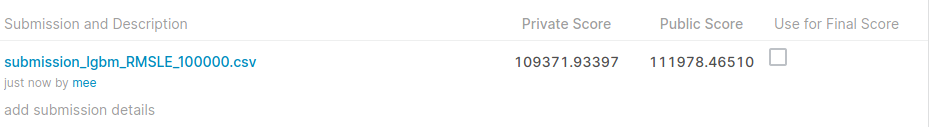

# 회고
처음 캐글 노드를 접했을 때, 노드를 따라가는 것만은 이해가 순조로웠다. 하지만 해커톤 캐글 대회를 통해 내가 알던 정보는 진짜 내가 아는 것이 아니고 이해를 못했다고 느꼈다. 실제로 공부한 내용을 응용하지도 못하는 나에게 너무 속상했다. 3일동안 캐글 코드만 공부하고 다른 분들의 노트북을 분석해보니 조금씩 눈에 보이고 그림이 그려졌다. 이후 캐글 이 프로젝트 제출을 위해 진행할 때, 더 순조롭게 코드가 읽혀져서 다시 흥미를 찾게 되었다. 처음 프로젝트를 진행할 때, Score 낮추는 것에 너무 지쳐 포기하고 제출하려 하였다. 조원분들의 도움으로 파라미터를 조금씩 수정해보니 최종 110000 이하의 Private Score 가 나타났다. 함께 공부하고 도움을 받을 수 있어 포기하지 않고 계속 나아갈 수 있는것 같아 든든하다^__^.
